## Context
- Code was run in a docker container (Dockerfile is in this folder) with latest version of code in the deepgoplus repository with the specifications listed in the ReadMe and the requirements.txt file
- Data was obtained from data.tar.gz which appears to be version 1.0.5
- Threshold was set at 0.3 and modification of alpha values is attempted

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import csv
import matplotlib.pyplot as plt
from Bio import SeqIO

In [25]:
results = {'deepgo version': [], 'threshold': [], 'data version': [], 'alpha': [], 'Matched classes':[], 
           'Unmatched code classes': [], 'Unmatched server classes':[], 'Jaccard similarity score':[]}


In [21]:
#file was generated by deepgoplus/main.py in a docker container
tsv_file = open("test1_modalpha0.55.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")
docker_pred = {}
name=''
for row in read_tsv:
    for count, r in enumerate(row):
        if count == 0:
            name = r
        elif count == 1:
            docker_pred[name] = np.array([r.split('|')])
        else:
            docker_pred[name] = np.append(docker_pred[name], [r.split('|')],axis=0)

# results['Diamond version'].append('2.0.2')
# results['python version'].append(3.7)
results['threshold'].append(0.3)
results['data version'].append('1.0.5')
results['deepgo version'].append('1.0.1')
results['alpha'].append("{NAMESPACES['mf']: 0.55, NAMESPACES['bp']: 0.55, NAMESPACES['cc']: 0.55}")
# results['Additional comments'].append('running DeepGo from pip removing hardcoded alphas in main.py')


In [6]:
#get results from DeepGo server
table = {}
fasta_sequences = SeqIO.parse(open('test1.fa'),'fasta')
for fasta in fasta_sequences:
    sequence =  '>' + fasta.id + '\n' + str(fasta.seq)

    #sending api request
    # Setting up configuration
    dataFormat = 'fasta'
    threshold = 0.3
    version = '1.0.1'

    #sequence = ">sp|P80386|AAKB1_RAT 5'-AMP-activated protein kinase subunit beta-1 OS=Rattus norvegicus GN=Prkab1 PE=1 SV=4" + "\n" 
    #sequence += "MGNTSSERAALERQAGHKTPRRDSSGGTKDGDRPKILMDSPEDADIFHTEEMKAPEKEEFLAWQHDLEVNEKAPAQARPTVFRWTGGGKEVYLSGSFNNWSKLPLTRSQNNFVAILDLPEGEHQYKFFVDGQWTHDPSEPIVTSQLGTVNNIIQVKKTDFEVFDALMVDSQKCSDVSELSSSPPGPYHQEPYISKPEERFKAPPILPPHLLQVILNKDTGISCDPALLPEPNHVMLNHLYALSIKDGVMVLSATHRYKKKYVTTLLYKPI"

    dataParametersToSend = {
        'data_format': dataFormat,
        'data': sequence,
        'threshold': threshold,
        'version': version}

    r = requests.post('https://deepgo.cbrc.kaust.edu.sa/deepgo/api/create', data=dataParametersToSend)                
    result = r.json();
      
    table[result['predictions'][0]['protein_info'].split(' ')[0]] = []

    for functions in result['predictions'][0]['functions']: 
        for count, f in enumerate(functions['functions']):
            table[result['predictions'][0]['protein_info'].split(' ')[0]] = np.append(table[result['predictions'][0]['protein_info'].split(' ')[0]], np.array([f[0],f[2]]))

    table[result['predictions'][0]['protein_info'].split(' ')[0]] =table[result['predictions'][0]['protein_info'].split(' ')[0]].reshape(-1,2)


### Compare matched scores

In [10]:
# Compare matched classes and scores
count=0
for classes in docker_pred['sp|P80386|AAKB1_RAT']:
    if classes[0] in table['sp|P80386|AAKB1_RAT']:
        print(table['sp|P80386|AAKB1_RAT'][table['sp|P80386|AAKB1_RAT'][:, 0] == classes[0]])
        print(classes)
        count +=1

print('Number of matched classes %s' %count)


[['GO:0005634' '0.583322629332542']]
['GO:0005634' '0.420']
[['GO:0005737' '0.873834550380707']]
['GO:0005737' '0.583']
[['GO:0005829' '0.598560392856598']]
['GO:0005829' '0.583']
[['GO:0110165' '0.953163534402847']]
['GO:0110165' '0.583']
[['GO:0005622' '0.945853590965271']]
['GO:0005622' '0.583']
[['GO:0043229' '0.708628118038177']]
['GO:0043229' '0.420']
[['GO:0043226' '0.737520128488541']]
['GO:0043226' '0.420']
[['GO:0043227' '0.721328228712082']]
['GO:0043227' '0.420']
[['GO:0043231' '0.708628118038177']]
['GO:0043231' '0.420']
[['GO:0050789' '0.534500777721405']]
['GO:0050789' '0.314']
[['GO:0009987' '0.686220347881317']]
['GO:0009987' '0.378']
[['GO:0065007' '0.6679328083992']]
['GO:0065007' '0.324']
[['GO:0008152' '0.603892922401428']]
['GO:0008152' '0.326']
[['GO:0071704' '0.538042962551117']]
['GO:0071704' '0.315']
[['GO:0044237' '0.523553460836411']]
['GO:0044237' '0.306']
[['GO:0070013' '0.329891368746758']]
['GO:0070013' '0.392']
[['GO:0043233' '0.350060895085335']]
['GO:

In [23]:
comparison = {}
extras_docker = {}
extras_api = {}
for protein in docker_pred:
    comparison[protein] = []
    extras_api[protein] = []
    extras_docker[protein] = []
    for functions in docker_pred[protein]:
        if functions[0] in table[protein]: 
            condition = [f for f in table[protein] if f[0] in functions[0]][0]
            condition = np.append(condition, functions[-1])
            #print(comparison[protein])
            comparison[protein] = np.append(comparison[protein], condition)
        else:
            extras_docker[protein].append(functions)
    
    for functions in table[protein]:
        if not functions[0] in docker_pred[protein]: extras_api[protein].append(functions)
    if len(comparison[protein]) > 0:
        comparison[protein] = comparison[protein].reshape(-1,3)
    
    results['Matched classes'].append(len(comparison[protein]))
    results['Unmatched code classes'].append(len(extras_docker[protein]))
    results['Unmatched server classes'].append(len(extras_api[protein]))
    
    results['Jaccard similarity score'].append(results['Matched classes'][-1]/((results['Matched classes'][-1]+results['Unmatched code classes'][-1])+results['Unmatched server classes'][-1]))



In [42]:
df = pd.DataFrame.from_dict(results)
#df
df.style.set_properties(subset=['alpha'], **{'width': '300px'})

,deepgo version,threshold,data version,alpha,Matched classes,Unmatched code classes,Unmatched server classes,Jaccard similarity score
0,1.0.1,0.300000,1.0.5,"{NAMESPACES['mf']: 0.55, NAMESPACES['bp']: 0.59, NAMESPACES['cc']: 0.46}",14,4,27,0.311111
1,1.0.1,0.300000,1.0.5,"{NAMESPACES['mf']: 0.5, NAMESPACES['bp']: 0.5, NAMESPACES['cc']: 0.5}",22,5,19,0.478261
2,1.0.1,0.300000,1.0.5,"{NAMESPACES['mf']: 0.63, NAMESPACES['bp']: 0.68, NAMESPACES['cc']: 0.48}",13,3,28,0.295455
3,1.0.1,0.300000,1.0.5,"{NAMESPACES['mf']: 0.55, NAMESPACES['bp']: 0.55, NAMESPACES['cc']: 0.55}",19,4,22,0.422222


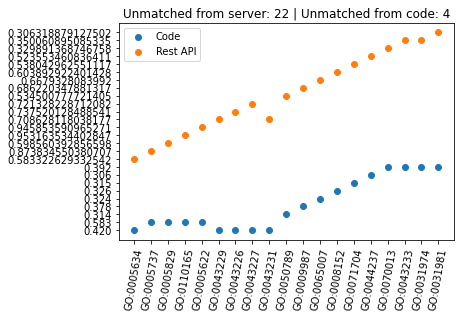

<Figure size 432x288 with 0 Axes>

In [44]:
for protein in comparison:
    
    X = np.c_[comparison[protein],np.arange(0, len(comparison[protein]))]
    #print(len(comparison[protein]))
    plt.scatter(X[:,-1],X[:,-2], label='Code')
    plt.scatter(X[:,-1],X[:,1], label='Rest API'), plt.xticks(np.arange(len(comparison[protein])), labels=X[:,0], rotation=80)
    plt.title('Unmatched from server: %s | Unmatched from code: %s'%(len(extras_api[protein]), len(extras_docker[protein])))
    plt.legend(), plt.figure();